In [1]:
import numpy as np
import pandas
import seaborn
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.preprocessing import MinMaxScaler

In [2]:
column_to_predict = 'median_house_value'
categories_columns = ['ocean_proximity']

data_frame = pandas.read_csv(filepath_or_buffer='cal-housing.csv')
#data_frame = data_frame.sample(frac=1).reset_index(drop=True)

columns_categories = pandas.DataFrame()

for c in categories_columns:
    column = pandas.get_dummies(data=data_frame[c], prefix=c + '_')
    columns_categories = pandas.concat((columns_categories, column), axis=1)

#data_frame.drop(columns=categories_columns, inplace=True)
#data_frame = pandas.concat([data_frame, columns_categories], axis=1)

outliers = data_frame[data_frame[column_to_predict] == 500001].index
data_frame.drop(outliers, inplace=True)

for c in data_frame.columns:
    if data_frame[c].hasnans:
        m = data_frame[c].mean()
        data_frame[c].fillna(value=m, inplace=True)
        
#columns_to_remove = ['households', 'total_bedrooms', column_to_predict]
#columns_to_remove = ['ocean_proximity', 'population', 'total_rooms', column_to_predict]
#columns_to_remove = ['latitude', 'population', 'total_rooms', column_to_predict]
columns_to_remove = ['ocean_proximity']

data_frame.drop(columns=columns_to_remove, inplace=True)

scaler = MinMaxScaler()
scaler.fit(data_frame)
data_frame = scaler.transform(data_frame)

cols = data_frame.shape[1]

X = data_frame[:, :cols - 1]
y = data_frame[:, cols - 1]

In [3]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=True)

In [4]:
regressor = Ridge(alpha=0.001, fit_intercept=True, normalize=True)
regressor.fit(x_train, y_train)

Ridge(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=True, random_state=None, solver='auto', tol=0.001)

In [5]:
y_pred = regressor.predict(x_test)

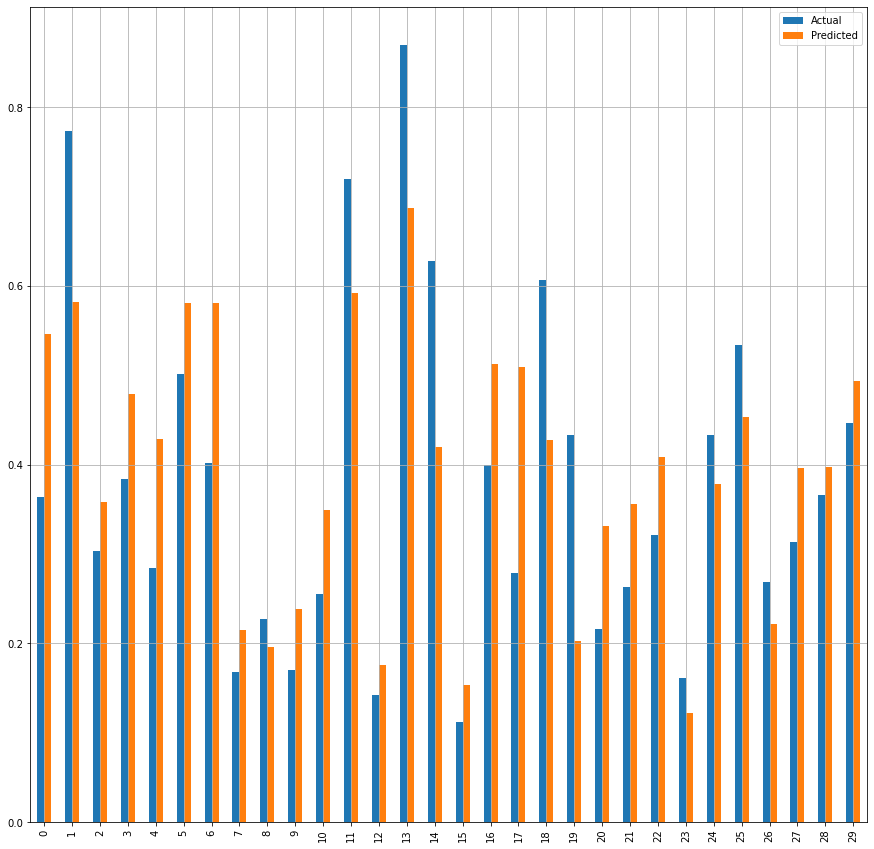

In [6]:
df = pandas.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df.head(30)

df1.plot(kind='bar', figsize=(15, 15))
plt.grid()
plt.show()

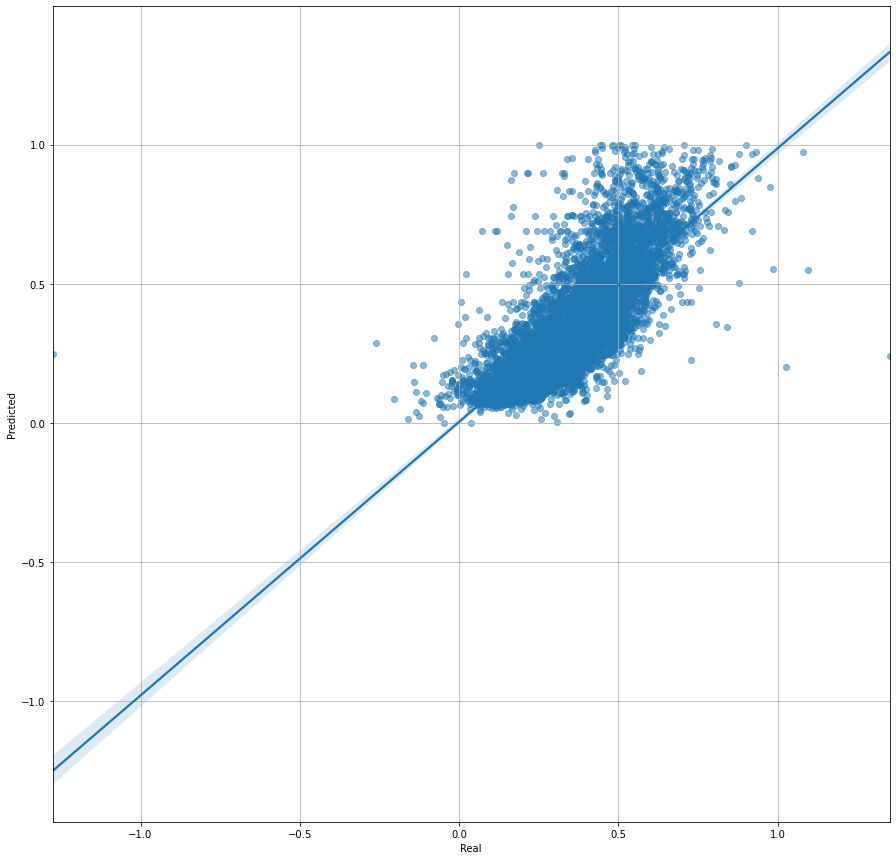

In [7]:
plt.figure(figsize=(15, 15))

seaborn.regplot(y_pred, y_test, scatter_kws={'alpha':0.5})

plt.xlabel('Real')
plt.ylabel('Predicted')

plt.grid()
plt.show()

In [8]:
print('R²:', metrics.r2_score(y_test, y_pred))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R²: 0.5915281774828652
Mean Absolute Error: 0.09433639733826021
Mean Squared Error: 0.01633021867125288
Root Mean Squared Error: 0.1277897439986984


### Cross validation

In [9]:
RMS = 'neg_mean_squared_error'
alpha_vals = np.linspace(0, 1, 50)

train_score__c, val_score__c = validation_curve(regressor, X, y, 'alpha', alpha_vals, cv=5, scoring=RMS, n_jobs=-1)

In [10]:
train_score_mean__c = -np.mean(train_score__c, axis=1)
train_score_std__c = np.std(train_score__c, axis=1)
val_score_mean__c = -np.mean(val_score__c, axis=1)
val_score_std__c = np.std(val_score__c, axis=1)

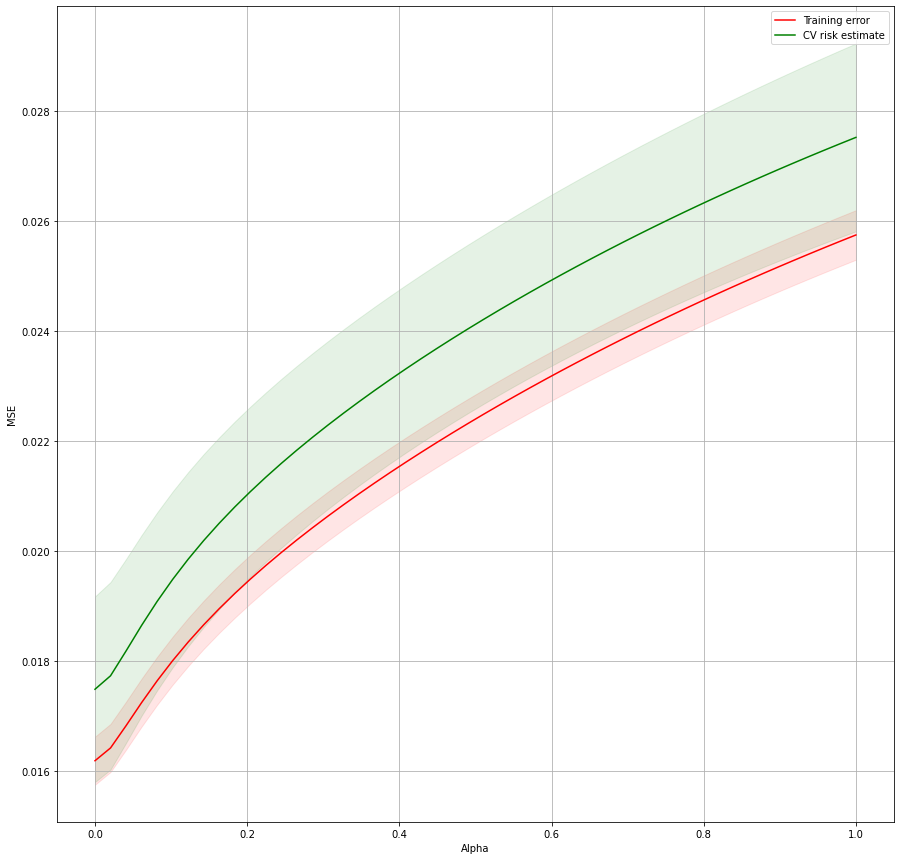

In [11]:
plt.figure(figsize=(15, 15))

plt.fill_between(alpha_vals, train_score_mean__c - train_score_std__c, train_score_mean__c + train_score_std__c, alpha=0.1, color="r")
plt.fill_between(alpha_vals, val_score_mean__c - val_score_std__c, val_score_mean__c + val_score_std__c, alpha=0.1, color="g")

plt.plot(alpha_vals, train_score_mean__c, color="r", label="Training error")
plt.plot(alpha_vals, val_score_mean__c, color="g", label="CV risk estimate")

plt.xlabel('Alpha')
plt.ylabel('MSE')

plt.grid()
plt.legend()
plt.show()